In [2]:
import pandas as pd
import numpy as np
import math
import random
import itertools
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('ggplot')
%matplotlib inline

In [4]:
# Read the shapefile
sf = shapefile.Reader("Shapefiles/geo_export_7766f064-29c1-4e13-b2d9-2e368707ff51.shp")

fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

# look at shapefile and merge with longitude and latitude
df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("location_i"), on="location_i")
df_loc


,borough,location_i,objectid,shape_area,shape_leng,zone,longitude,latitude
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,-74.171533,40.689483
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,-73.822478,40.610824
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,-73.844953,40.865747
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,-73.977725,40.724137
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,-74.187558,40.550664
...,...,...,...,...,...,...,...,...
258,Brooklyn,256.0,256.0,0.000169,0.067915,Williamsburg (South Side),-73.959332,40.710978
259,Bronx,259.0,259.0,0.000395,0.126750,Woodlawn/Wakefield,-73.856334,40.899061
260,Queens,260.0,260.0,0.000422,0.133514,Woodside,-73.906851,40.746603
261,Manhattan,261.0,261.0,0.000034,0.027120,World Trade Center,-74.012643,40.709120


#### Auxiliary Functions

In [5]:
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['location_i']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["location_i", "longitude", "latitude"])

def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

def draw_region_map(ax, sf, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        #sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        #sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8), \
        #             boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    ax.set_facecolor(ocean)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])


def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())+1/1000,max(heat.values())+1/1000))
    
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['location_i']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['shape_area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

#### Plot Boroughs and Taxi Zones

c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


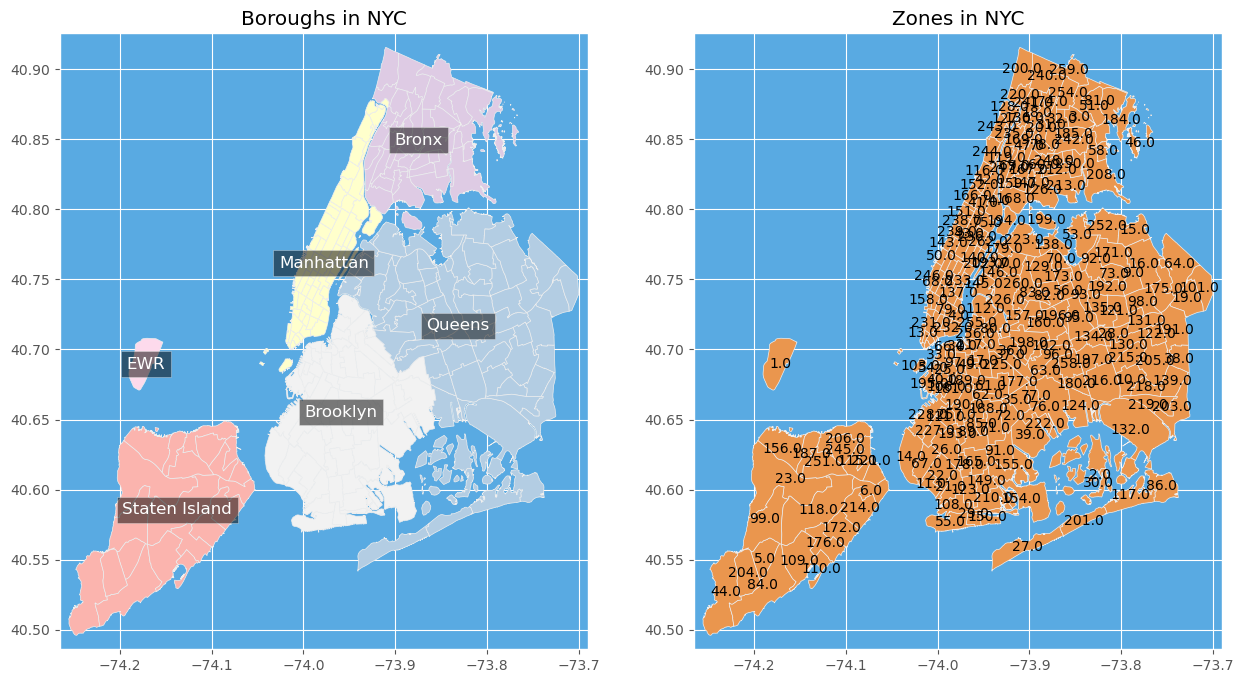

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf)

##### Trips per borough 2014-2019

In [10]:
green = pd.read_csv("Green_Cab_data/merged_grouped.csv")
yellow = pd.read_csv("Yellow_Cab_data/merged_grouped.csv")
fhv = pd.read_csv("For_Hire_Vehicle_data/merged_grouped.csv")
# sum the variable trip_number grouped by PULocationID
green_pickup = green.groupby("PULocationID").agg({"trip_number": "sum"}).reset_index()
yellow_pickup = yellow.groupby("PULocationID").agg({"trip_number": "sum"}).reset_index()
fhv_pickup = fhv.groupby("PUlocationID").agg({"trip_number": "sum"}).reset_index()
# add column "borough" to green_pickup by using variables borough and location_id from df_loc only keeping location_i
green_pickup = green_pickup.merge(df_loc[["borough", "location_i", "zone"]], left_on="PULocationID", right_on="location_i").drop("PULocationID", axis=1)
yellow_pickup = yellow_pickup.merge(df_loc[["borough", "location_i", "zone"]], left_on="PULocationID", right_on="location_i").drop("PULocationID", axis=1)
fhv_pickup = fhv_pickup.merge(df_loc[["borough", "location_i", "zone"]], left_on="PUlocationID", right_on="location_i").drop("PUlocationID", axis=1)
# dictionary with the highest numver of pickups
PUtop3_green = green_pickup.sort_values(by=['trip_number'], ascending=False).set_index("location_i").head(3)
PUtop3_yellow = yellow_pickup.sort_values(by=['trip_number'], ascending=False).set_index("location_i").head(3)
PUtop3_fhv = fhv_pickup.sort_values(by=['trip_number'], ascending=False).set_index("location_i").head(3)
PUcount_green = dict(zip(green_pickup['location_i'].tolist(), green_pickup['trip_number'].tolist()))
PUcount_yellow = dict(zip(yellow_pickup['location_i'].tolist(), yellow_pickup['trip_number'].tolist()))
PUcount_fhv = dict(zip(fhv_pickup['location_i'].tolist(), fhv_pickup['trip_number'].tolist()))

C:\Users\max-admin\AppData\Local\Temp\ipykernel_8440\21694087.py:107: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


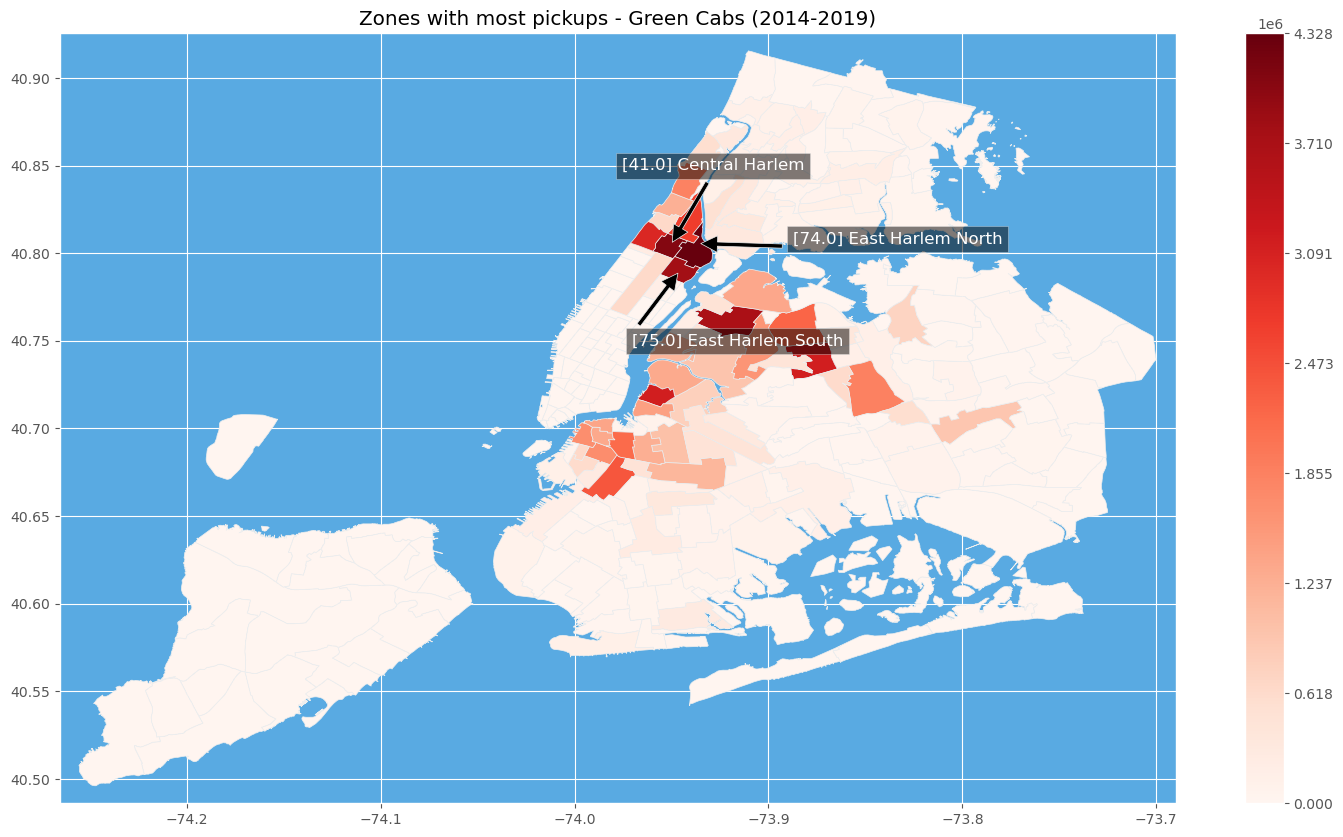

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,8))
ax.set_title("Zones with most pickups - Green Cabs (2014-2019)")
draw_zone_map(ax, sf, heat=PUcount_green, text=PUtop3_green.index.tolist())



C:\Users\max-admin\AppData\Local\Temp\ipykernel_8440\21694087.py:107: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),


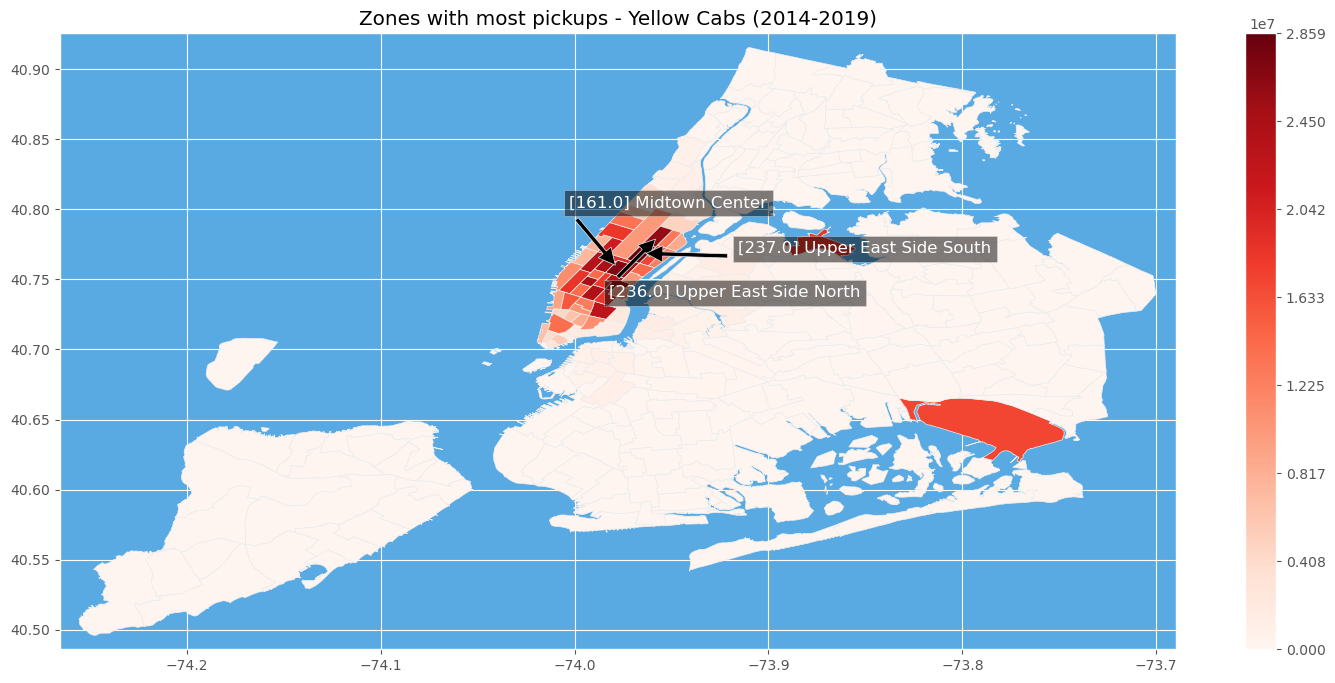

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,8))
ax.set_title("Zones with most pickups - Yellow Cabs (2014-2019)")
draw_zone_map(ax, sf, heat=PUcount_yellow, text=PUtop3_yellow.index.tolist())


C:\Users\max-admin\AppData\Local\Temp\ipykernel_8440\21694087.py:107: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),


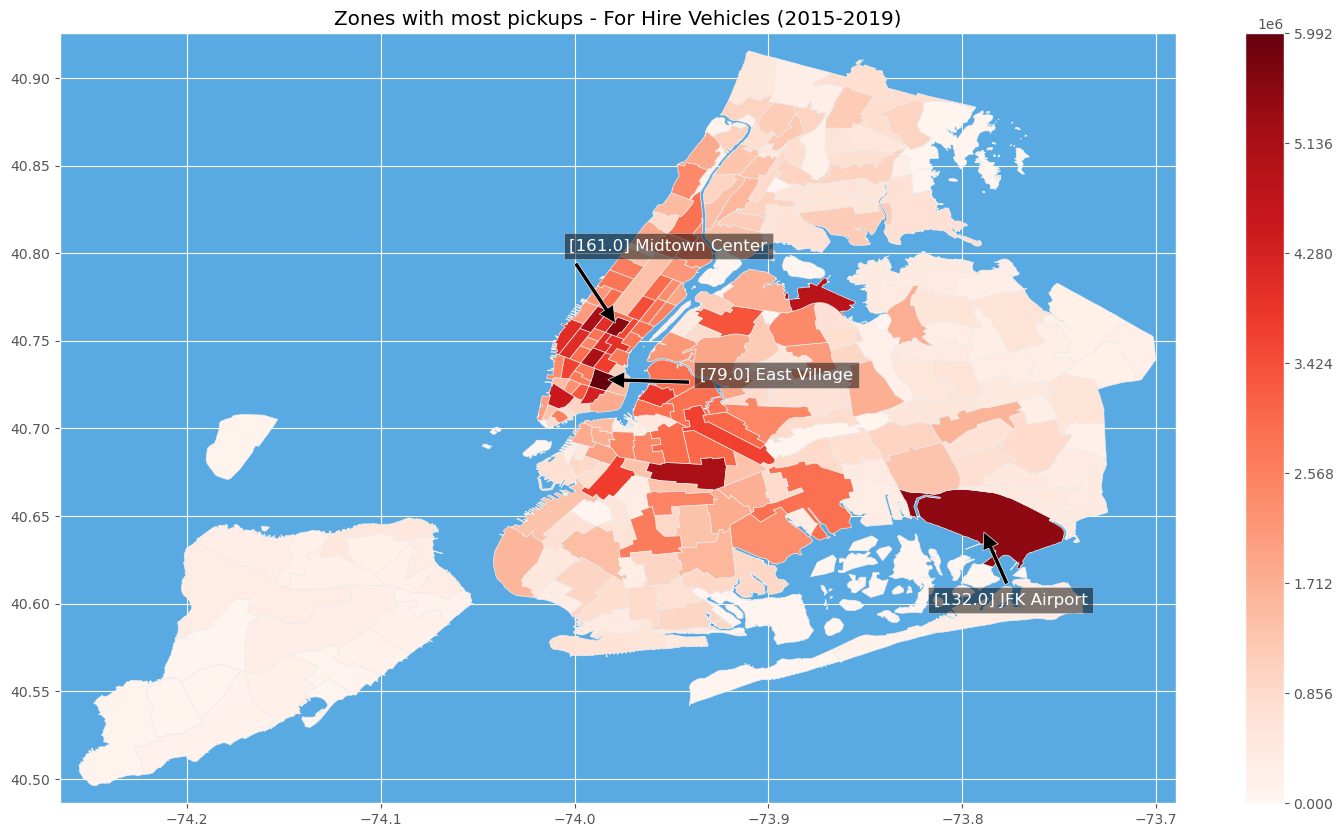

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,10))
ax.set_title("Zones with most pickups - For Hire Vehicles (2015-2019)")
draw_zone_map(ax, sf, heat=PUcount_fhv, text=PUtop3_fhv.index.tolist())

##### Hot Days Pickup Locations

In [34]:
# slice the dataframe where only days are kept where tmax_obs is higher than 30
hotdays_green = green[green['tmax_obs']>33].groupby("PULocationID").agg({"trip_number": "sum"}).reset_index()
hotdays_yellow = yellow[yellow['tmax_obs']>33].groupby("PULocationID").agg({"trip_number": "sum"}).reset_index()
hotdays_fhv = fhv[fhv['tmax_obs']>33].groupby("PUlocationID").agg({"trip_number": "sum"}).reset_index()

# add column "borough" to green_pickup by using variables borough and location_id from df_loc only keeping location_i
green_pickup = hotdays_green.merge(df_loc[["borough", "location_i", "zone"]], left_on="PULocationID", right_on="location_i").drop("PULocationID", axis=1)
yellow_pickup = hotdays_yellow.merge(df_loc[["borough", "location_i", "zone"]], left_on="PULocationID", right_on="location_i").drop("PULocationID", axis=1)
fhv_pickup = hotdays_fhv.merge(df_loc[["borough", "location_i", "zone"]], left_on="PUlocationID", right_on="location_i").drop("PUlocationID", axis=1)

# dictionary with the highest numver of pickups
PUtop3_green = green_pickup.sort_values(by=['trip_number'], ascending=False).set_index("location_i").head(3)
PUtop3_yellow = yellow_pickup.sort_values(by=['trip_number'], ascending=False).set_index("location_i").head(3)
PUtop3_fhv = fhv_pickup.sort_values(by=['trip_number'], ascending=False).set_index("location_i").head(3)
PUcount_green = dict(zip(green_pickup['location_i'].tolist(), green_pickup['trip_number'].tolist()))
PUcount_yellow = dict(zip(yellow_pickup['location_i'].tolist(), yellow_pickup['trip_number'].tolist()))
PUcount_fhv = dict(zip(fhv_pickup['location_i'].tolist(), fhv_pickup['trip_number'].tolist()))


##### Plot Zones with highest number of pickups on days with max. temperature succeeding 30 degrees C

C:\Users\max-admin\AppData\Local\Temp\ipykernel_9068\21694087.py:107: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


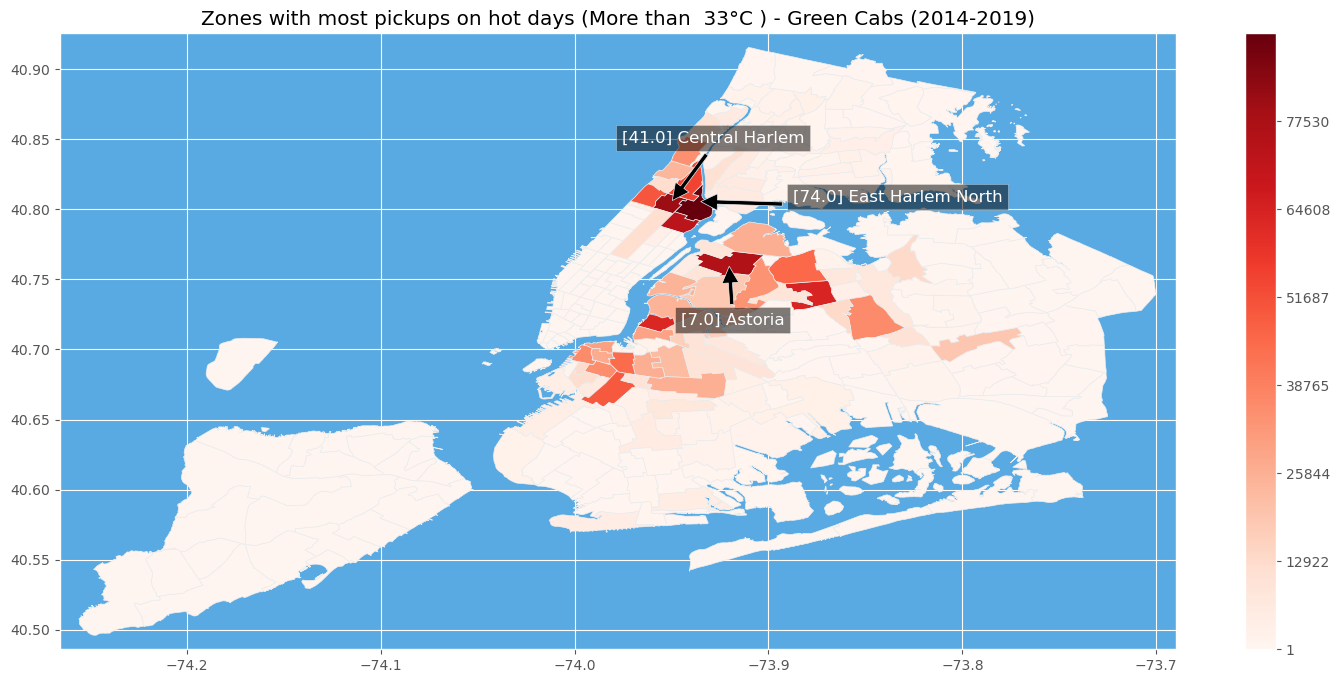

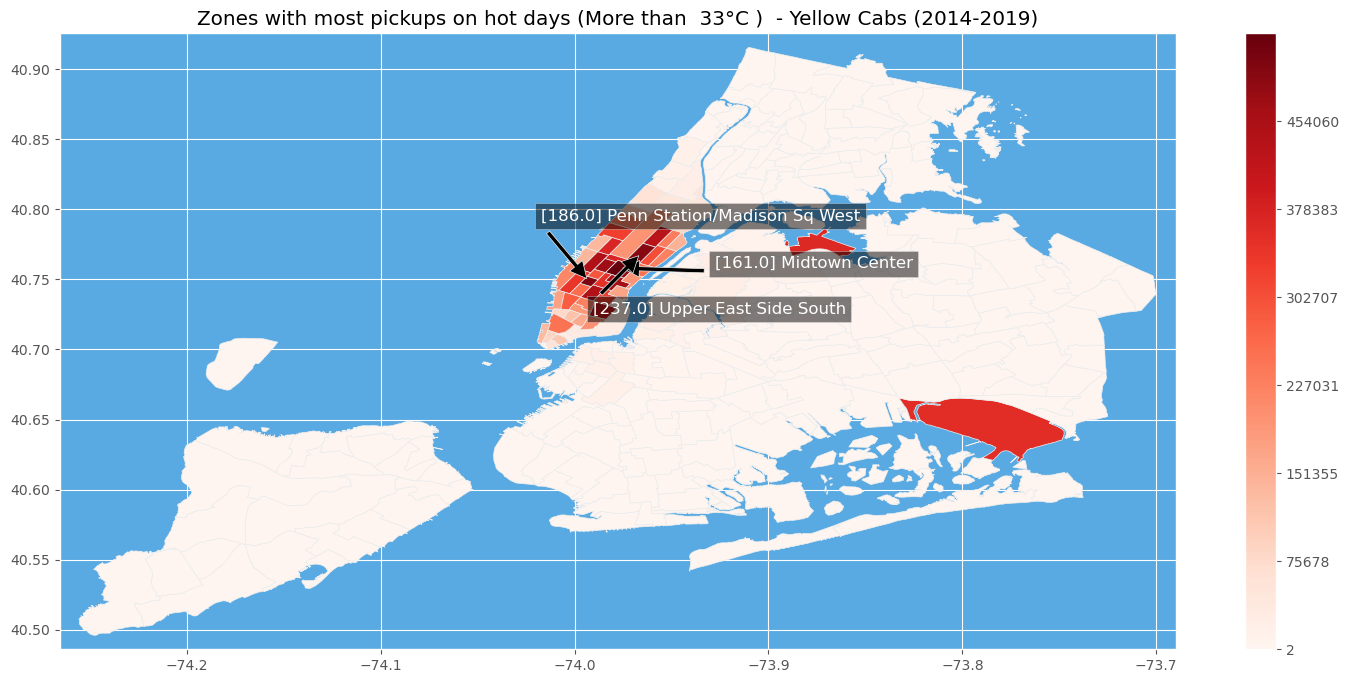

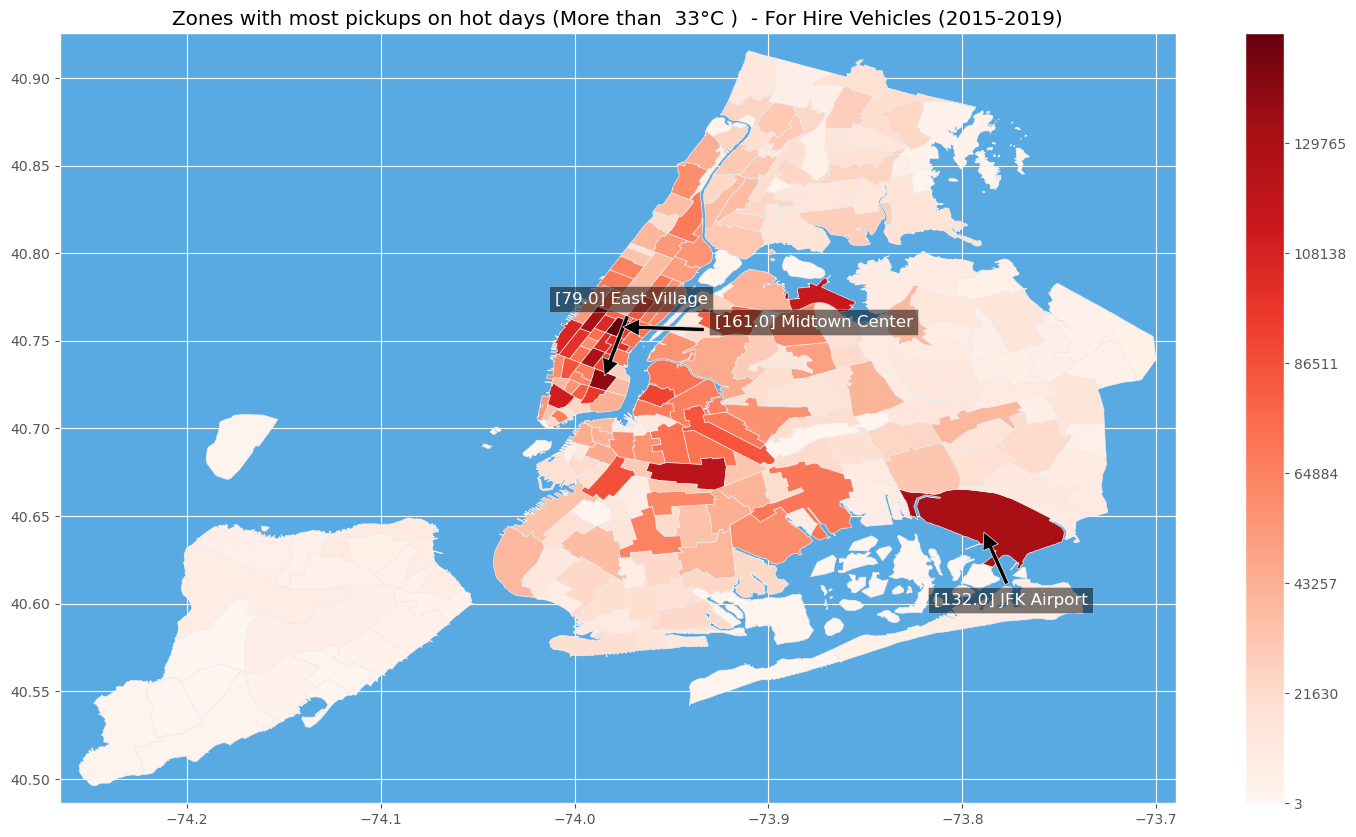

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,8))
ax.set_title("Zones with most pickups on hot days (More than  33°C ) - Green Cabs (2014-2019)")
draw_zone_map(ax, sf, heat=PUcount_green, text=PUtop3_green.index.tolist())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,8))
ax.set_title("Zones with most pickups on hot days (More than  33°C )  - Yellow Cabs (2014-2019)")
draw_zone_map(ax, sf, heat=PUcount_yellow, text=PUtop3_yellow.index.tolist())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,10))
ax.set_title("Zones with most pickups on hot days (More than  33°C )  - For Hire Vehicles (2015-2019)")
draw_zone_map(ax, sf, heat=PUcount_fhv, text=PUtop3_fhv.index.tolist())

#### Zones with most dropoffs 

c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


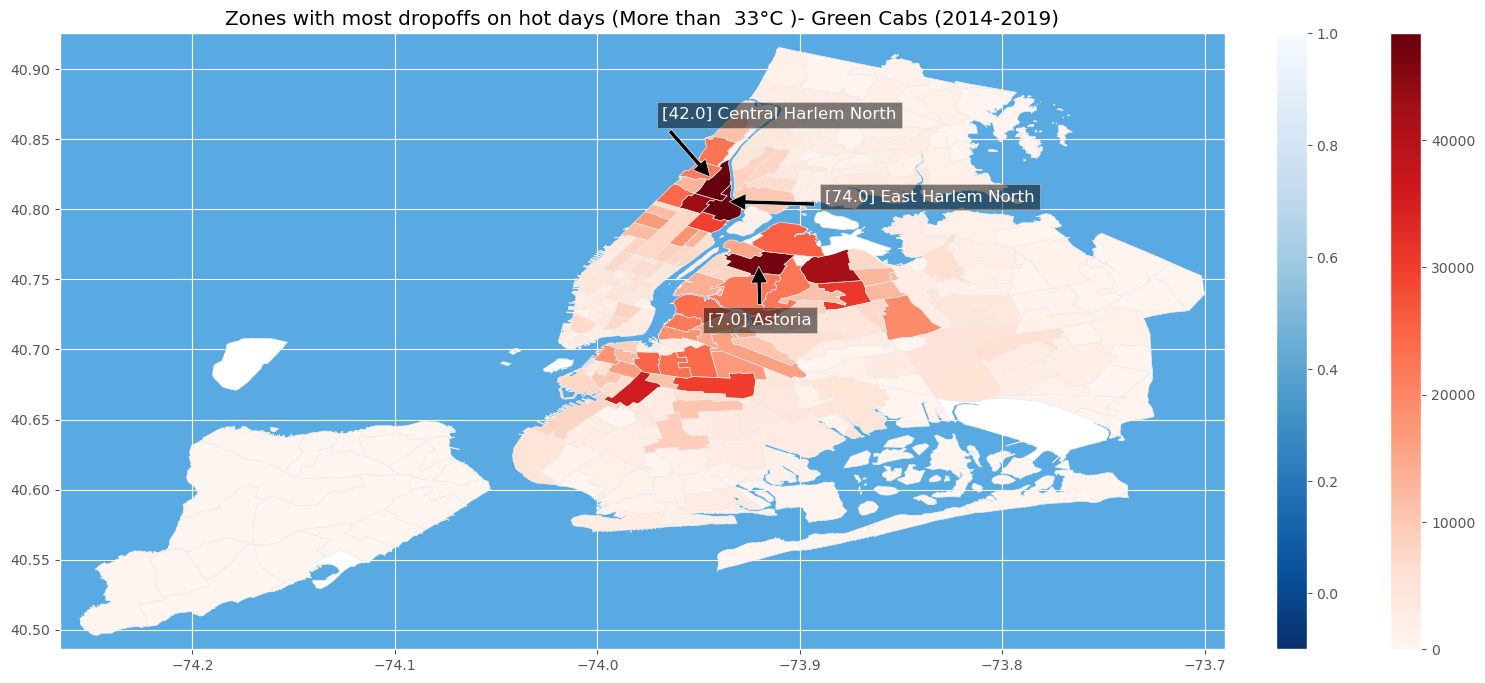

In [22]:
green = pd.read_csv("Green_Cab_data/merged_grouped_DO.csv")
# slice the dataframe where only days are kept where tmax_obs is higher than 30

green = green[green['tmax_obs']>33].groupby("DOLocationID").agg({"trip_number": "sum"}).reset_index()
# add column "borough" to green_pickup by using variables borough and location_id from df_loc only keeping location_i
green_pickup = green.merge(df_loc[["borough", "location_i", "zone"]], left_on="DOLocationID", right_on="location_i").drop("DOLocationID", axis=1)
# dictionary with the highest numver of pickups
PUtop3_green = green_pickup.sort_values(by=['trip_number'], ascending=False).set_index("location_i").head(3)
PUcount_green = dict(zip(green_pickup['location_i'].tolist(), green_pickup['trip_number'].tolist()))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,8))
ax.set_title("Zones with most dropoffs on hot days (More than  33°C )- Green Cabs (2014-2019)")
draw_zone_map_neg(ax, sf, heat=PUcount_green, text=PUtop3_green.index.tolist())

#### Trip Distance: Is there Heterogeneity in Long Trips / Short Trips

In [31]:
pooled = pd.read_csv("Pooled_data/data_regression_PU.csv")

# only consider days where tmax_obs is higher than 30
pooled = pooled[pooled['tmax_obs']>=30]

# Calculate the 99.9th percentile value
outlier_threshold = pooled['trip_distance_mean'].quantile(0.999)

# Drop rows where 'trip_distance_mean' is greater than the outlier threshold or equal to zero
pooled = pooled[(pooled['trip_distance_mean'] <= outlier_threshold) & (pooled['trip_distance_mean'] >= 0)]



pooled_distance = pooled.groupby("PULocationID").agg({"trip_distance_mean": "mean"}).reset_index()



pooled_distance = pooled_distance.merge(df_loc[["borough", "location_i", "zone"]], left_on="PULocationID", right_on="location_i").drop("PULocationID", axis=1)


PUtop3_distance = pooled_distance.sort_values(by=['trip_distance_mean'], ascending=False).set_index("location_i").head(3)


C:\Users\max-admin\AppData\Local\Temp\ipykernel_24860\21694087.py:107: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


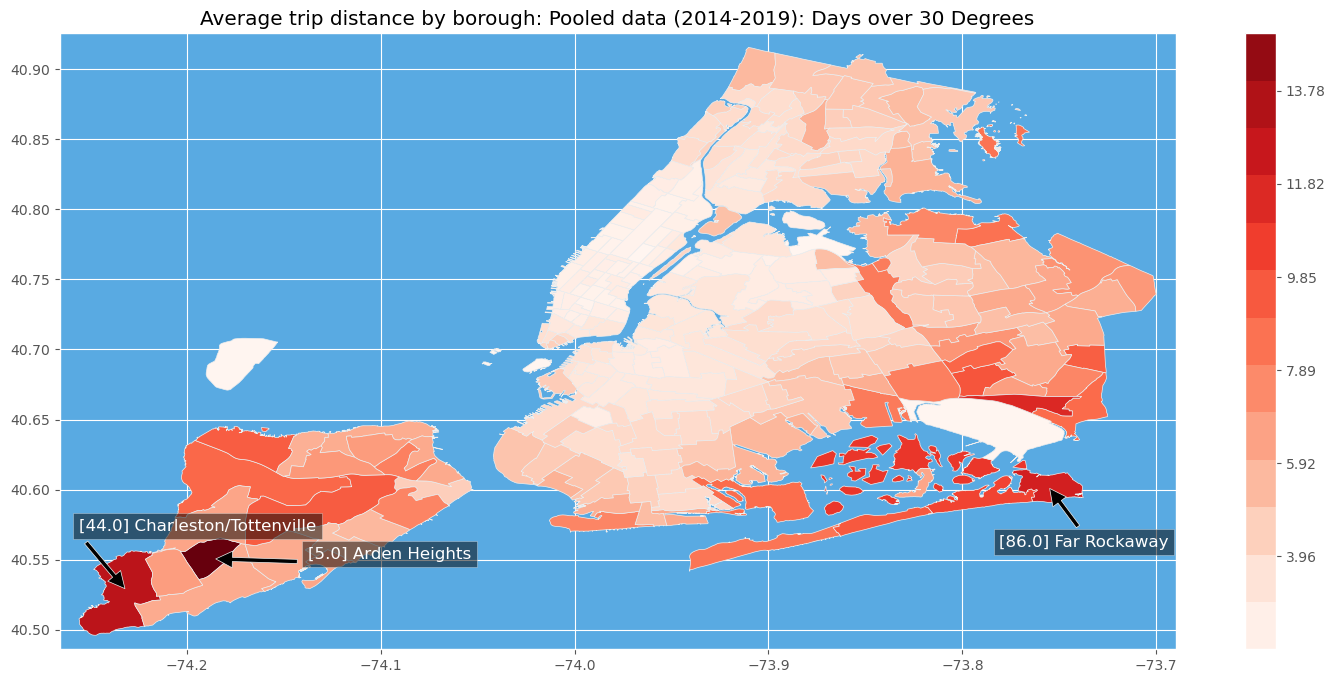

In [32]:
distance_dict = dict(zip(pooled_distance['location_i'].tolist(),pooled_distance['trip_distance_mean'].tolist()))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,8))
ax.set_title("Average trip distance by borough: Pooled data (2014-2019): Days over 30 Degrees")
draw_zone_map(ax, sf, heat=distance_dict, text=PUtop3_distance.index.tolist())

In [33]:
avg_origin_coronapark.average_daily_trips.describe()

count    258.000000
mean       2.384755
std        1.597844
min        1.000000
25%        1.387039
50%        1.847053
75%        2.744452
max       11.216890
Name: average_daily_trips, dtype: float64

### Origin CoronaPark

In [23]:

def draw_zone_map_neg(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    col = continent
    
    # colorbar
    if len(heat) != 0:

         # Separate positive and negative values for different color maps
        pos_norm = mpl.colors.Normalize(vmin=0, vmax=max(heat.values()))
        neg_norm = mpl.colors.Normalize(vmin=min(heat.values()), vmax=0)

        # Define two color maps
        pos_cm = plt.get_cmap('Reds')
        neg_cm = plt.get_cmap('Blues_r')



        # Create and set the ScalarMappable objects for colorbars
        pos_sm = plt.cm.ScalarMappable(cmap=pos_cm, norm=pos_norm)
        neg_sm = plt.cm.ScalarMappable(cmap=neg_cm, norm=neg_norm)
        pos_sm.set_array([])
        neg_sm.set_array([])

        # Display the colorbars
        plt.colorbar(pos_sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
        plt.colorbar(neg_sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['location_i']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = (1, 1, 1, 1)
        else:
            if loc_id not in heat:
                col = (1, 1, 1, 1)  # Default color if no data
            else:
                heat_value = heat[loc_id]
                if heat_value > 0:
                    col = pos_cm(pos_norm(heat_value))
                elif heat_value < 0:
                    col = neg_cm(neg_norm(heat_value))
                else:
                    col = (1, 1, 1, 1)


        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['shape_area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [27]:
avg_origin_coronapark

,Unnamed: 0,PULocationID,average_daily_trips,average_daily_trips_25,deviation
0,0,2.0,1.000000,1.000000,0.000000
1,1,3.0,1.546512,2.121212,0.270930
2,2,4.0,1.747253,1.681416,-0.039156
3,3,5.0,1.000000,1.000000,0.000000
4,4,6.0,1.333333,1.500000,0.111111
...,...,...,...,...,...
253,253,261.0,2.013129,2.000000,-0.006565
254,254,262.0,2.833684,2.832536,-0.000405
255,255,263.0,2.804184,2.932377,0.043716
256,256,264.0,1.383821,1.525547,0.092902


C:\Users\max-admin\AppData\Local\Temp\ipykernel_11040\21694087.py:107: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


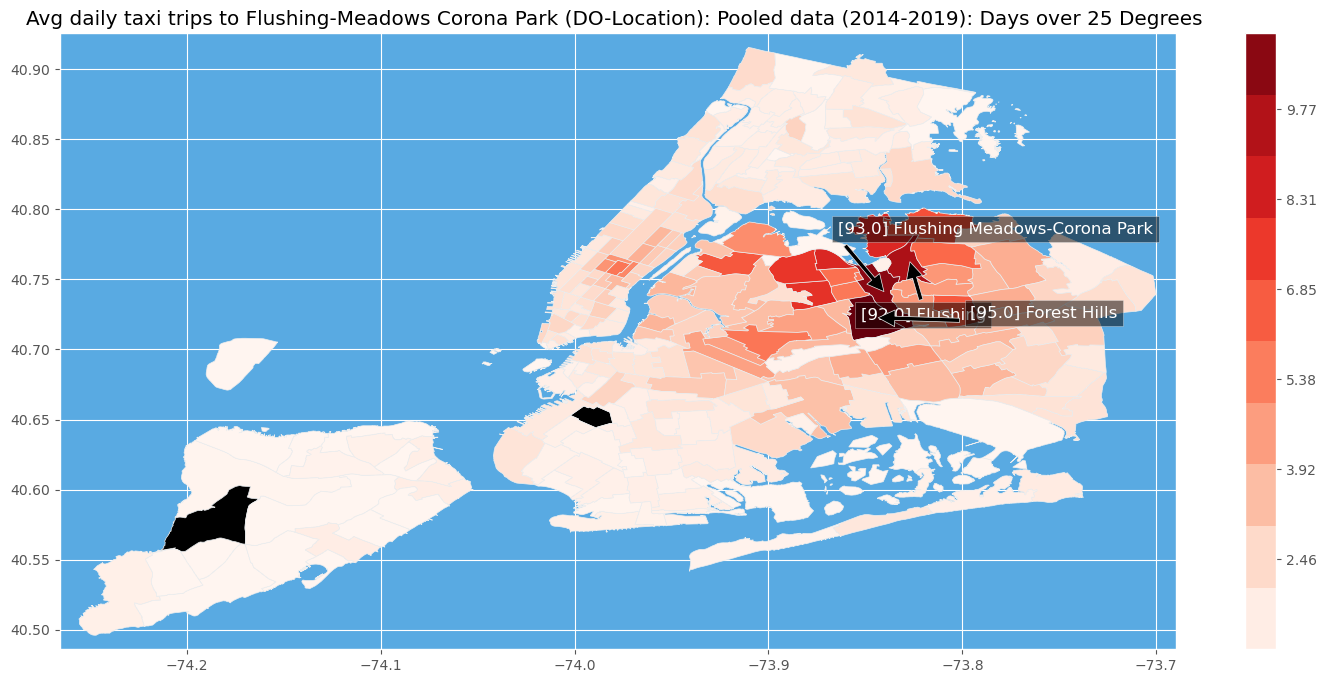

In [32]:
avg_origin_coronapark = pd.read_csv("Pooled_data/avg_destination_coronapark.csv")

avg_og = avg_origin_coronapark.merge(df_loc[["borough", "location_i", "zone"]], left_on="PULocationID", right_on="location_i").drop("PULocationID", axis=1)


PUtop3_trips = avg_og.sort_values(by=['average_daily_trips_25'], ascending=False).set_index("location_i").head(3)

origin_dict = dict(zip(avg_og['location_i'].tolist(),avg_og['average_daily_trips_25'].tolist()))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,8))
ax.set_title("Avg daily taxi trips to Flushing-Meadows Corona Park (DO-Location): Pooled data (2014-2019): Days over 25 Degrees ")
draw_zone_map(ax, sf, heat=origin_dict, text=PUtop3_trips.index.tolist())


In [8]:
avg_destination_coronapark = pd.read_csv("Pooled_data/avg_destination_coronapark.csv")